### This notebook converts the reconstructed-level simulation to pickled .npy files for training a regression model.

The generation steps are outlined here: https://github.com/miguelignacio/inputdata
The regression notebook is simply called TowardsCodesign.ipynb located in this repo.
**Next Step: Save as HDF5, better interface for ML applications**

In [1]:
#%matplotlib notebook
import uproot as ur
import k3d
import numpy as np
import awkward as ak

from matplotlib import pyplot as plt, colors
plt.rcParams["figure.figsize"] = [10.00, 6.]
plt.rcParams["figure.autolayout"] = True

## Get file and TTree, print branches, convert to array

In [2]:
input_file = "rec_piplus_Energy_0-100GeV.root"
output_npy = "pionplus_EnergyVar_10k"

e_events = ur.open("%s:events"%(input_file)) #1k 20GeV electrons march3
e_events["HcalEndcapPHitsReco.energy"].array(library="pd") #pandas gives a nice quick view of the data

entry  subentry
0      0           5.004883e-04
       1           2.172851e-03
       2           5.938721e-03
       3           3.295898e-04
       4           8.300781e-04
                       ...     
9999   430         1.125900e+14
       431         1.125900e+14
       432         1.125900e+14
       433         1.125900e+14
       434         3.479004e-04
Length: 4549530, dtype: float32

In [3]:
#def get_vector(events,varname='HcalEndcapHits',energy='energy'):
def get_vector(events,varname='HcalEndcapHitsP',energy='energy'):
    E = events["%s.%s"%(varname,energy)].array(library='np')
    x = events["%s.position.x"%varname].array(library='np')
    y = events["%s.position.y"%varname].array(library='np')
    z = events["%s.position.z"%varname].array(library='np')
    #theta = events["%s.polar.theta"%varname].array(library='np')
    #phi = events["%s.polar.phi"%varname].array(library='np')

    return E,x, y, z, theta, phi

def get_truth(gen_events,varname="MCParticles"):
    pdgID = gen_events["%s.%s"%(varname,'PDG')].array(library='np')
    status = gen_events["%s.%s"%(varname,'simulatorStatus')].array(library='np')
    genStatus = gen_events["%s.%s"%(varname,'generatorStatus')].array(library='np')
    pex = gen_events["%s.%s"%(varname,'momentum.x')].array(library='np')
    pey = gen_events["%s.%s"%(varname,'momentum.y')].array(library='np')
    pez = gen_events["%s.%s"%(varname,'momentum.z')].array(library='np')
    mass = gen_events["%s.%s"%(varname,'mass')].array(library='np')

    return pdgID,status, genStatus,pex,pey,pez,mass

In [4]:
E = {}
x = {}
y = {}
z  = {}
theta={}
phi = {}

In [5]:
for i in ['HcalEndcapP','EcalEndcapP']:#,'TrackerEndcap','VertexEndcap']:
    tag = 'e_' + i
    E[tag], x[tag], y[tag],z[tag],theta[tag],phi[tag] = get_vector(e_events,varname="%sHitsReco"%i)

In [6]:
print(len(E["e_HcalEndcapP"]))
print(np.shape(E["e_HcalEndcapP"]))

10000
(10000,)


## Get MC

In [7]:
print(len(e_events))

99


In [8]:
def get_GeneratedValues(events):
    mc = {} 
    mc['pdgID'], mc['status'], mc['genStatus'], mc['pex'],mc['pey'], mc['pez'], mc['mass']= get_truth(events)
    
    truth_P = []
    truth_Th = []
    N_events = 10000
    for ievt in range(0,N_events):
        for i in range(len(mc['pdgID'][ievt])):
            if(mc['genStatus'][ievt][i] !=1): continue
            px = mc['pex'][ievt][i]
            py =  mc['pey'][ievt][i]
            pz = mc['pez'][ievt][i]
            pt =  np.sqrt(px*px + py*py)
            p = np.sqrt(px*px+py*py+pz*pz)
            theta = np.arccos(pz/p)*180/np.pi
            #print(ievt)
            #print('MC particle ID ', mc['pdgID'][0][i],  'genStatus ', mc['genStatus'][0][i],
            #   ' px = %2.2f, py=%2.2f, pz=%2.2f'%(mc['pex'][0][i],mc['pey'][0][i],mc['pez'][0][i]))
            #print('p = %2.2f , theta =%2.2f'%(p, theta))
        truth_P.append(p)
        truth_Th.append(theta)
    return truth_P, truth_Th

truth = {}
truth['e_p'], truth['e_theta'] = get_GeneratedValues(e_events)
print(len(truth['e_p']))

mc_truth = {}
mc_truth['true_energy']=truth['e_p']
mc_truth['true_angle']=truth['e_theta']

10000


## Get Clusters

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

/tmp/ipykernel_1769/2068353929.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ECAL_x = x[key][ievt][mask]
/tmp/ipykernel_1769/2068353929.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ECAL_y = y[key][ievt][mask]
/tmp/ipykernel_1769/2068353929.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ECAL_E =

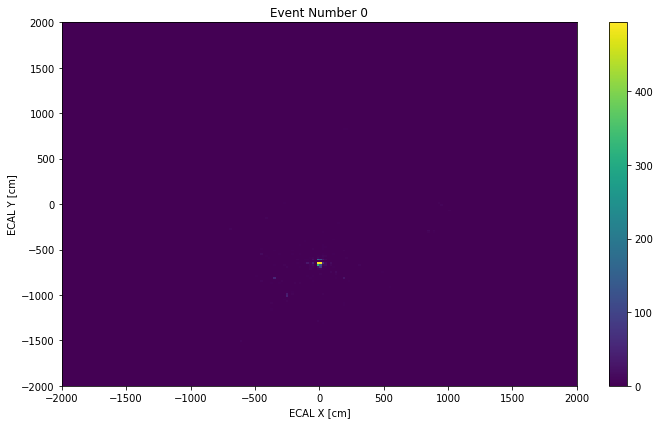

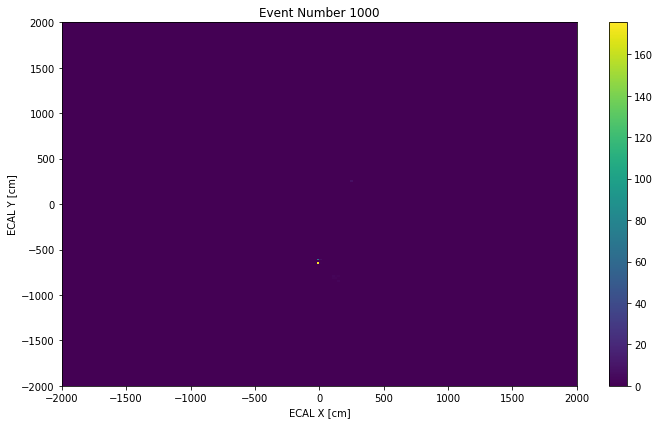

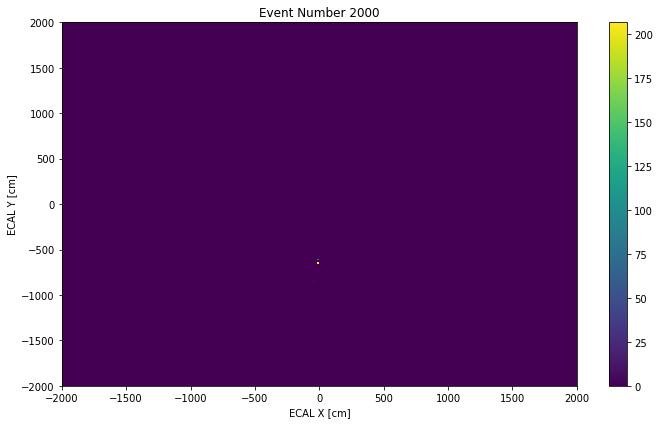

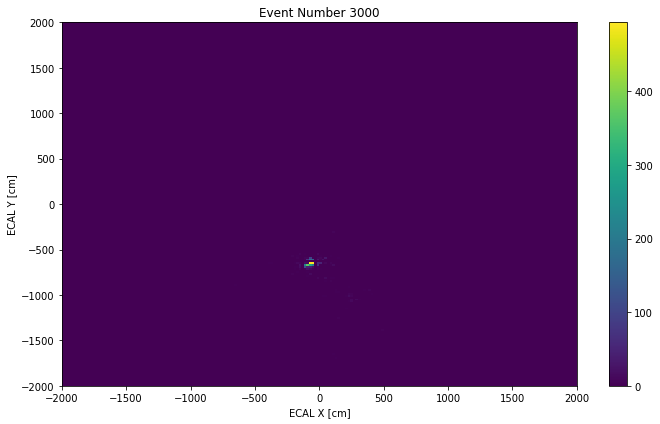

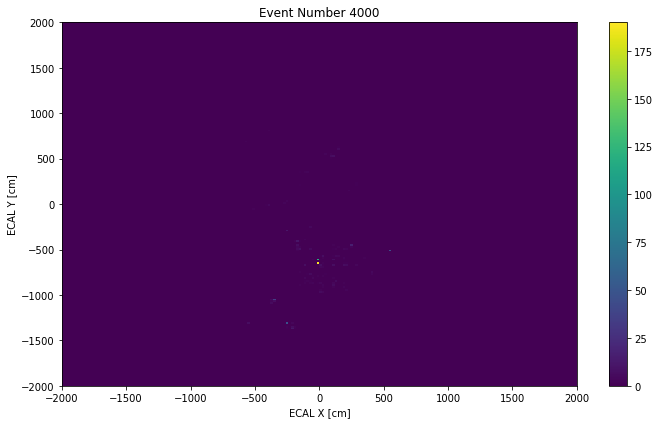

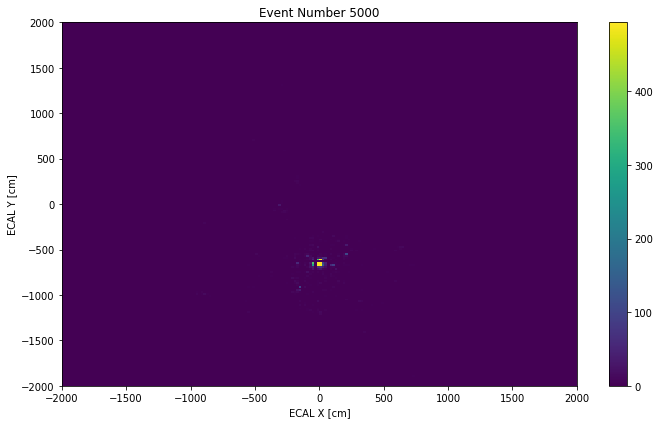

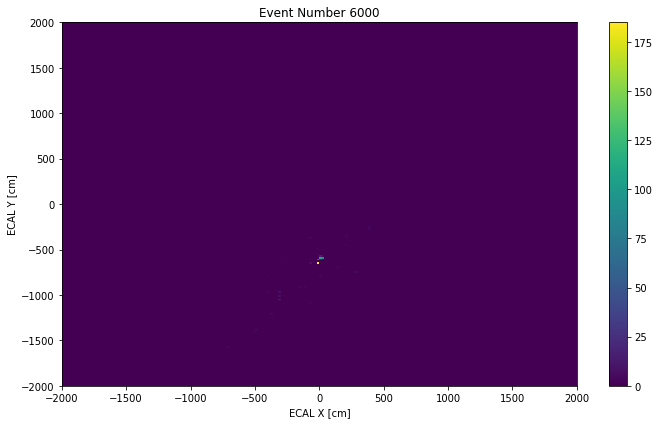

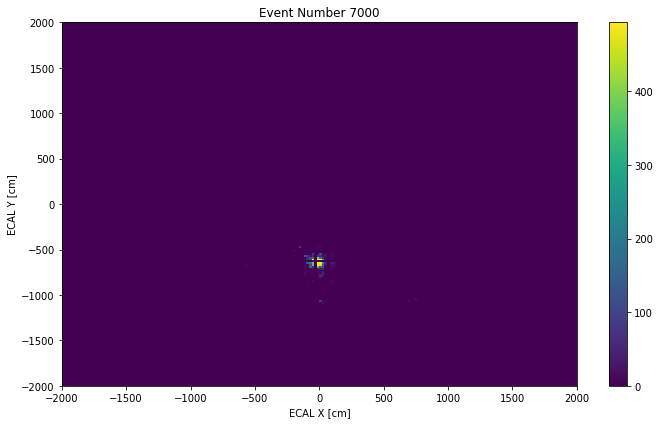

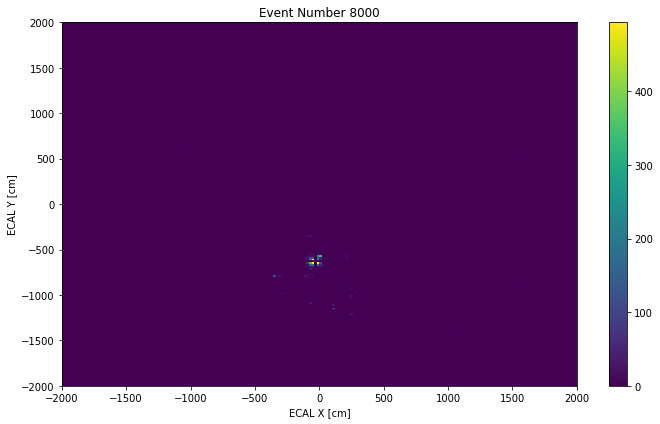

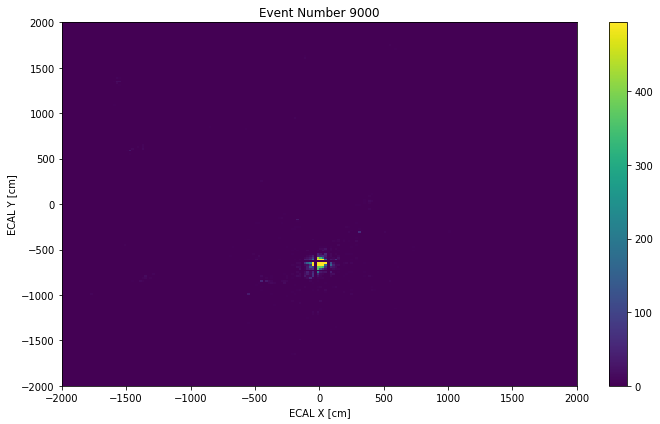

In [10]:
#loop over events
data = []
mc_truth = []

nevents = 10000
for ievt in range(0,nevents): #can the range be determined from the root file?
    for part_type in ['e']:#pi0 previously. See 'Get Hits' section
        ECAL = []
        key = '%s_EcalEndcapP'%(part_type)
        
        
        #mask = (E[key][ievt]>0.005)
        mask = [(E[key][ievt]>0.001) & (E[key][ievt]<10000)]
        #mask = [(E[key][ievt]<10)]
        #print(E)
   
        ECAL_x = x[key][ievt][mask]
        ECAL_y = y[key][ievt][mask]
        ECAL_E = E[key][ievt][mask]*1000.0 #(MeV)
        
        #print('NUmber of CELLS ', len(ECAL_E))
    
        #print(cell_x)
        #print(cell_E)
        
        N = 10
        if (ievt%(nevents/N)==0): #do for every N portion of the dataset
            fig, ax = plt.subplots()
            c = ax.hist2d(ECAL_x,ECAL_y, weights=ECAL_E,label=part_type + ' evt #%i'%(ievt), 
                         bins=[200,200],range=([[-2000, 2000], [-2000,2000]]))
            fig.colorbar(c[3], ax=ax)         
            ax.set_title("Event Number %i"%(ievt))
            ax.set_xlabel("ECAL X [cm]")
            ax.set_ylabel("ECAL Y [cm]")
        
        suma_ECAL = np.sum(E[key][ievt])
        #print('Event Number %i'%(ievt) , ' Suma ECAL =%2.2f GeV'%suma_ECAL)
        
        #### HCAL 
        
        #ECAL.append(list(cell_E))
        
        key = '%s_HcalEndcapP'%(part_type)

        #print('######################   Entering HCAL   ##########################')
        
        event_array = []
        for length_1 in range(100,500,20): #20 iterations
            for length_2 in range(100,500,20): #20 iterations (20x20=400 images). Changes z-position of HCal boundary for now
                Image = {}
                Image['ECAL_E'] = ECAL_E
                Image['ECAL_x'] = ECAL_x
                Image['ECAL_y'] = ECAL_y
                Image['HCAL1_E'] = []
                Image['HCAL2_E'] = []
                Image['HCAL3_E'] = []
                Image['HCAL1_x'] = []
                Image['HCAL2_x'] = []
                Image['HCAL3_x'] = []
                Image['HCAL1_y'] = []
                Image['HCAL2_y'] = []
                Image['HCAL3_y'] = []
                Image['boundary'] = (length_1, length_2)
                if(length_1+length_2>999): continue
                #fig,ax  = plt.subplots(1,4,figsize=(20,4),sharex=True, sharey=True)
    
                #print('Length 1= ', length_1,' legnth 2' , length_2)
                z_offset = 3800 #[mm]
                z_max = z_offset + 1200 #HCAL ~ 1.2m
                
                for iz, zbins in enumerate([(z_offset,z_offset+length_1),
                    (z_offset+length_1, z_offset+length_1+length_2),(z_offset+length_1+length_2,z_max)]):
                    #print('############')
                    mask = [(z[key][ievt]>zbins[0]) & (z[key][ievt]<zbins[1]) & (E[key][ievt]>0.0)]
                    if(np.sum(mask)<1): continue
                    cell_x = x[key][ievt][mask]
                    cell_y = y[key][ievt][mask]
                    cell_E = E[key][ievt][mask] *1000.0 # eV to MEV
                    #print(cell_E)
                    #c = ax[iz+1].hist2d(cell_x,cell_y, weights=cell_E,label=part_type + ' evt #%i'%(ievt), 
                    #    bins=[40,40],range=([[-2000, 2000], [-2000,2000]]))
                    #fig.colorbar(c[3], ax=ax[iz+1])       
                    Image['HCAL%i_E'%(iz+1)].append(cell_E)
                    #print(iz," ,",cell_E)
                    Image['HCAL%i_x'%(iz+1)].append(cell_x)
                    Image['HCAL%i_y'%(iz+1)].append(cell_y)

                    #ax[iz+1].set_title('%i, %i'%(zbins[0],zbins[1]))
                    #HCAL['%i_x'%(iz+1)].append(list(cell_x))
                    #HCAL['%i_y'%(iz+1)].append(list(cell_y))

        #HCAL_tot = [HCAL['1'],HCAL['2'],HCAL['3'],(3200,3400)]  
        #print([HCAL,(length_1,length_2)])
                event_array.append(Image)
        
        data.append(event_array)
        ##END OF EVENT
        #ax[0].set_title('ECAL \n %s event'%(part_type))
        #for iz in range(3):
        #    ax[iz+1].set_title('HCAL %i \n %s event, %2.0f GeV'%(iz,part_type,truth[part_type+'_p']))

        #ax[0].legend()
        #for a in ax:
        #    a.set_xticklabels([])
        #    a.set_yticklabels([])
        #plt.subplots_adjust(wspace=0, hspace=0.5)
#TOTAL = []





#print(data[ievt])

#print('Primera entry')
#print(data[0][1])
#print('Second entry')

#print(data[0][2])
#print('Thriy')

#print(data[0][3])

#print ('HCAL 1', HCAL['1'])
#print ('HCAL 2 ', HCAL['2'])
#print ('HCAL 3 ', HCAL['3'])

In [11]:
with open("%s.npy"%(output_npy), 'wb') as f:
    np.save(f, mc_truth)
    np.save(f, data)

In [12]:
with open('%s.npy'%(output_npy), 'rb') as f:
    header = np.load(f,allow_pickle=True)
    print(header)
    print(type(header)) #figure this out (google)
    data = np.load(f,allow_pickle=True)
    print(data)
    ievt = 99  #could loop
    print('number of images in event', len(data[ievt]))
    ## Here we loop over all "images", which are created by integrating HCAL sampling layers defing 3 sectors defined 
    ## by two z position that define boundary. Note for all images ECAL is the same (no longitudinal separation in ECAL)
    for im in range(len(data[ievt])):
        print('#  IMAGE NUMBER %i############\n\n\n'%im)
        print(data[ievt][im]) #This is a dictionary
        print(data[ievt][im].keys())
        #print('HCAL1 x [mm] \n', data[ievt][im]['HCAL1_x']) ##This is x of HCAL#1 image im
        #print('HCAL1 y [mm]\n', data[ievt][im]['HCAL1_y']) ##This is y of HCAL#1 image im
        print('HCAL1 E [GeV]\n', data[ievt][im]['HCAL1_E']) ## this is E of HCAL#1 image im
        #print('HCAL2 x [mm]\n', data[ievt][im]['HCAL2_x']) ##This is x of HCAL#2 image im
        #print('HCAL2 y [mm]\n', data[ievt][im]['HCAL2_y']) ##This is y of HCAL#2 image im
        print('HCAL2 E [mm]\n', data[ievt][im]['HCAL2_E']) ## this is E of HCAL#2 image im
        #print('HCAL3 x [mm]\n',data[ievt][im]['HCAL3_x']) ##This is x of HCAL#3 image im
        #print('HCAL3 y [mm]\n',data[ievt][im]['HCAL3_y']) ##This is y of HCAL#3 image im
        print('HCAL3 E [mm]\n',data[ievt][im]['HCAL3_E']) ## this is E of HCAL#3 image im
        #print('ECAL x [mm]\n',data[ievt][im]['ECAL_E']) ## this is E of ECAL image im
        #print('ECAL y [mm]\n',data[ievt][im]['ECAL_x']) ## this is x of ECAL image im
        print('ECAL E [mm]\n',data[ievt][im]['ECAL_y']) ## this is x of ECAL image im
        #print('Boundaries\n',data[ievt][im]['boundary'])  ## This are the boundaries (z positions of long layers) used to created image


[]
<class 'numpy.ndarray'>
[[{'ECAL_E': array([165.20691  , 493.89648  , 493.89648  ,  19.714355 ,  12.451172 ,
           9.613037 ,  56.106567 , 113.87634  ,  11.749268 ,   1.373291 ,
           3.250122 ,   1.3885498,   1.1901855,   2.3040771,   1.2054443,
           1.0070801,   8.651733 ,   3.250122 ,   8.255005 ,   1.0070801,
          41.09192  , 118.10303  , 315.7959   ,  31.555176 ,   5.203247 ,
           4.333496 ,   4.486084 ,   2.319336 ,   6.7749023,   5.3100586,
           7.0495605,   5.0354004,   3.6773682,   3.4332275,   5.79834  ,
           2.2125244,   1.0223389,   5.79834  ,   1.159668 ,   2.105713 ,
           2.609253 ,   7.2631836,   6.8511963,   2.243042 ,   1.3580322,
           1.876831 ,   2.9907227,   2.1972656,  30.075073 ,   3.692627 ,
           2.8076172,   2.0599365,  18.997192 ,   4.486084 ,  11.59668  ,
           1.4953613,   3.5705566,   5.0201416,   6.7596436,   1.0986328,
          79.75769  ,   3.8604736,   1.8157959,   1.7852783,   2.2125244,


{'ECAL_E': array([424.27063  , 493.89648  , 493.89648  , 133.89587  ,  70.78552  ,
       307.06787  ,  30.075073 ,   6.3476562,   4.3640137,   7.171631 ,
        33.309937 ,  13.412476 ,  23.1781   ,  49.88098  , 493.89648  ,
        15.808105 , 149.27673  ,   7.7056885,  70.84656  ,  10.391235 ,
         3.8757324,  80.322266 ,  36.40747  ,  19.607544 ,  17.01355  ,
        10.009766 ,  20.004272 ,   5.0811768,   2.1514893,   3.8146973,
         2.6397705, 152.54211  ,   1.2054443,  23.208618 ,   4.5928955,
         2.5024414,   1.4038086,   2.3498535,   2.0446777,   2.7923584,
         1.9989014,  32.11975  ,  96.23718  ,   1.6937256,   3.692627 ,
         2.4261475,   1.5563965, 103.22571  ,  39.07776  ,  15.518188 ,
        10.528564 ,  17.974854 ,   9.872437 ,   6.4697266,   3.1433105,
         1.2207031,   1.663208 ,   2.105713 ,   3.1433105,  58.59375  ,
         3.3721924,  14.312744 ,   1.0681152,   3.2043457,   1.9073486,
         7.461548 ,   1.373291 ,   2.456665 ,   7.232

{'ECAL_E': array([424.27063  , 493.89648  , 493.89648  , 133.89587  ,  70.78552  ,
       307.06787  ,  30.075073 ,   6.3476562,   4.3640137,   7.171631 ,
        33.309937 ,  13.412476 ,  23.1781   ,  49.88098  , 493.89648  ,
        15.808105 , 149.27673  ,   7.7056885,  70.84656  ,  10.391235 ,
         3.8757324,  80.322266 ,  36.40747  ,  19.607544 ,  17.01355  ,
        10.009766 ,  20.004272 ,   5.0811768,   2.1514893,   3.8146973,
         2.6397705, 152.54211  ,   1.2054443,  23.208618 ,   4.5928955,
         2.5024414,   1.4038086,   2.3498535,   2.0446777,   2.7923584,
         1.9989014,  32.11975  ,  96.23718  ,   1.6937256,   3.692627 ,
         2.4261475,   1.5563965, 103.22571  ,  39.07776  ,  15.518188 ,
        10.528564 ,  17.974854 ,   9.872437 ,   6.4697266,   3.1433105,
         1.2207031,   1.663208 ,   2.105713 ,   3.1433105,  58.59375  ,
         3.3721924,  14.312744 ,   1.0681152,   3.2043457,   1.9073486,
         7.461548 ,   1.373291 ,   2.456665 ,   7.232

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'ECAL_E': array([424.27063  , 493.89648  , 493.89648  , 133.89587  ,  70.78552  ,
       307.06787  ,  30.075073 ,   6.3476562,   4.3640137,   7.171631 ,
        33.309937 ,  13.412476 ,  23.1781   ,  49.88098  , 493.89648  ,
        15.808105 , 149.27673  ,   7.7056885,  70.84656  ,  10.391235 ,
         3.8757324,  80.322266 ,  36.40747  ,  19.607544 ,  17.01355  ,
        10.009766 ,  20.004272 ,   5.0811768,   2.1514893,   3.8146973,
         2.6397705, 152.54211  ,   1.2054443,  23.208618 ,   4.5928955,
         2.5024414,   1.4038086,   2.3498535,   2.0446777,   2.7923584,
         1.9989014,  32.11975  ,  96.23718  ,   1.6937256,   3.692627 ,
         2.4261475,   1.5563965, 103.22571  ,  39.07776  ,  15.518188 ,
        10.528564 ,  17.974854 ,   9.872437 ,   6.4697266,   3.1433105,
         1.2207031,   1.663208 ,   2.105713 ,   3.1433105,  58.59375  ,
         3.3721924,  14.312744 ,   1.0681152,   3.2043457,   1.9073486,
         7.461548 ,   1.373291 ,   2.456665 ,   7.232

{'ECAL_E': array([424.27063  , 493.89648  , 493.89648  , 133.89587  ,  70.78552  ,
       307.06787  ,  30.075073 ,   6.3476562,   4.3640137,   7.171631 ,
        33.309937 ,  13.412476 ,  23.1781   ,  49.88098  , 493.89648  ,
        15.808105 , 149.27673  ,   7.7056885,  70.84656  ,  10.391235 ,
         3.8757324,  80.322266 ,  36.40747  ,  19.607544 ,  17.01355  ,
        10.009766 ,  20.004272 ,   5.0811768,   2.1514893,   3.8146973,
         2.6397705, 152.54211  ,   1.2054443,  23.208618 ,   4.5928955,
         2.5024414,   1.4038086,   2.3498535,   2.0446777,   2.7923584,
         1.9989014,  32.11975  ,  96.23718  ,   1.6937256,   3.692627 ,
         2.4261475,   1.5563965, 103.22571  ,  39.07776  ,  15.518188 ,
        10.528564 ,  17.974854 ,   9.872437 ,   6.4697266,   3.1433105,
         1.2207031,   1.663208 ,   2.105713 ,   3.1433105,  58.59375  ,
         3.3721924,  14.312744 ,   1.0681152,   3.2043457,   1.9073486,
         7.461548 ,   1.373291 ,   2.456665 ,   7.232

{'ECAL_E': array([424.27063  , 493.89648  , 493.89648  , 133.89587  ,  70.78552  ,
       307.06787  ,  30.075073 ,   6.3476562,   4.3640137,   7.171631 ,
        33.309937 ,  13.412476 ,  23.1781   ,  49.88098  , 493.89648  ,
        15.808105 , 149.27673  ,   7.7056885,  70.84656  ,  10.391235 ,
         3.8757324,  80.322266 ,  36.40747  ,  19.607544 ,  17.01355  ,
        10.009766 ,  20.004272 ,   5.0811768,   2.1514893,   3.8146973,
         2.6397705, 152.54211  ,   1.2054443,  23.208618 ,   4.5928955,
         2.5024414,   1.4038086,   2.3498535,   2.0446777,   2.7923584,
         1.9989014,  32.11975  ,  96.23718  ,   1.6937256,   3.692627 ,
         2.4261475,   1.5563965, 103.22571  ,  39.07776  ,  15.518188 ,
        10.528564 ,  17.974854 ,   9.872437 ,   6.4697266,   3.1433105,
         1.2207031,   1.663208 ,   2.105713 ,   3.1433105,  58.59375  ,
         3.3721924,  14.312744 ,   1.0681152,   3.2043457,   1.9073486,
         7.461548 ,   1.373291 ,   2.456665 ,   7.232

{'ECAL_E': array([424.27063  , 493.89648  , 493.89648  , 133.89587  ,  70.78552  ,
       307.06787  ,  30.075073 ,   6.3476562,   4.3640137,   7.171631 ,
        33.309937 ,  13.412476 ,  23.1781   ,  49.88098  , 493.89648  ,
        15.808105 , 149.27673  ,   7.7056885,  70.84656  ,  10.391235 ,
         3.8757324,  80.322266 ,  36.40747  ,  19.607544 ,  17.01355  ,
        10.009766 ,  20.004272 ,   5.0811768,   2.1514893,   3.8146973,
         2.6397705, 152.54211  ,   1.2054443,  23.208618 ,   4.5928955,
         2.5024414,   1.4038086,   2.3498535,   2.0446777,   2.7923584,
         1.9989014,  32.11975  ,  96.23718  ,   1.6937256,   3.692627 ,
         2.4261475,   1.5563965, 103.22571  ,  39.07776  ,  15.518188 ,
        10.528564 ,  17.974854 ,   9.872437 ,   6.4697266,   3.1433105,
         1.2207031,   1.663208 ,   2.105713 ,   3.1433105,  58.59375  ,
         3.3721924,  14.312744 ,   1.0681152,   3.2043457,   1.9073486,
         7.461548 ,   1.373291 ,   2.456665 ,   7.232

ECAL E [mm]
 [ -620.  -645.  -645.  -620.  -645.  -670.  -620.  -620.  -595.  -745.
  -695.  -720.  -720.  -695.  -670.  -695.  -670.  -720.  -645.  -595.
  -570.  -670.  -695.  -620.  -695.  -695.  -645.  -645.  -670.  -395.
  -395.  -670.  -670.  -670.  -645.  -645.  -670.  -695.  -595.  -945.
  -945.  -645.  -595.  -595.  -620.  -545.  -595.  -595.  -570.  -720.
  -695.  -670.  -895.  -895.  -870.  -820.  -845.  -895.  -920.  -820.
  -745.  -745.  -770.  -545.  -520.  -595.  -695.  -470.  -495.  -520.
   680.  -345.  -720.  -570.  -595.  -645.  -770.  -770.  -620.  -670.
   105.  -545.  -295.  -320.  -195.  -720.  -645.  -620. -1195.  -720.
  -820.  -845.  -545.  -420.]
#  IMAGE NUMBER 358############



{'ECAL_E': array([424.27063  , 493.89648  , 493.89648  , 133.89587  ,  70.78552  ,
       307.06787  ,  30.075073 ,   6.3476562,   4.3640137,   7.171631 ,
        33.309937 ,  13.412476 ,  23.1781   ,  49.88098  , 493.89648  ,
        15.808105 , 149.27673  ,   7.7056885,  70.84656 

{'ECAL_E': array([424.27063  , 493.89648  , 493.89648  , 133.89587  ,  70.78552  ,
       307.06787  ,  30.075073 ,   6.3476562,   4.3640137,   7.171631 ,
        33.309937 ,  13.412476 ,  23.1781   ,  49.88098  , 493.89648  ,
        15.808105 , 149.27673  ,   7.7056885,  70.84656  ,  10.391235 ,
         3.8757324,  80.322266 ,  36.40747  ,  19.607544 ,  17.01355  ,
        10.009766 ,  20.004272 ,   5.0811768,   2.1514893,   3.8146973,
         2.6397705, 152.54211  ,   1.2054443,  23.208618 ,   4.5928955,
         2.5024414,   1.4038086,   2.3498535,   2.0446777,   2.7923584,
         1.9989014,  32.11975  ,  96.23718  ,   1.6937256,   3.692627 ,
         2.4261475,   1.5563965, 103.22571  ,  39.07776  ,  15.518188 ,
        10.528564 ,  17.974854 ,   9.872437 ,   6.4697266,   3.1433105,
         1.2207031,   1.663208 ,   2.105713 ,   3.1433105,  58.59375  ,
         3.3721924,  14.312744 ,   1.0681152,   3.2043457,   1.9073486,
         7.461548 ,   1.373291 ,   2.456665 ,   7.232

{'ECAL_E': array([424.27063  , 493.89648  , 493.89648  , 133.89587  ,  70.78552  ,
       307.06787  ,  30.075073 ,   6.3476562,   4.3640137,   7.171631 ,
        33.309937 ,  13.412476 ,  23.1781   ,  49.88098  , 493.89648  ,
        15.808105 , 149.27673  ,   7.7056885,  70.84656  ,  10.391235 ,
         3.8757324,  80.322266 ,  36.40747  ,  19.607544 ,  17.01355  ,
        10.009766 ,  20.004272 ,   5.0811768,   2.1514893,   3.8146973,
         2.6397705, 152.54211  ,   1.2054443,  23.208618 ,   4.5928955,
         2.5024414,   1.4038086,   2.3498535,   2.0446777,   2.7923584,
         1.9989014,  32.11975  ,  96.23718  ,   1.6937256,   3.692627 ,
         2.4261475,   1.5563965, 103.22571  ,  39.07776  ,  15.518188 ,
        10.528564 ,  17.974854 ,   9.872437 ,   6.4697266,   3.1433105,
         1.2207031,   1.663208 ,   2.105713 ,   3.1433105,  58.59375  ,
         3.3721924,  14.312744 ,   1.0681152,   3.2043457,   1.9073486,
         7.461548 ,   1.373291 ,   2.456665 ,   7.232

In [13]:
#sf_ECAL = 0.253
#sf_HCAL = 0.025
    #print('Energy = %2.3f'%(suma_ECAL/sf_ECAL+suma_HCAL/sf_HCAL))
    ##suma_HCAL = np.sum(E[key][ievt])
    #print(suma_HCAL/sf_HCAL)

In [14]:
header=np.load('%s.npy'%(output_npy),allow_pickle=True)
print(header.item().get('true_energy'))

ValueError: can only convert an array of size 1 to a Python scalar